In [1]:
!pip install lightgbm

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import lightgbm as gbm

In [2]:
nlp = pd.read_csv('data/data_nlp.csv')

In [5]:
nlp.isna().sum()

id              0
price           0
brand           0
description     0
categories      0
sub_category    0
dtype: int64

In [44]:
nlp.shape

(15795, 6)

In [3]:
nlp = nlp.fillna('unk')
#nlp = nlp.reset_index(drop=True)

In [7]:
nlp.head()

,id,price,brand,description,categories,sub_category
0,eac7efa5dbd3d667f26eb3d3ab504464,4.0,Hornby,Product Description Hornby 2014 Catalogue Box ...,Toys,Model Trains & Railway Sets
1,b17540ef7e86e461d37f3ae58b7b72ac,21.0,FunkyBuys,Size Name:Large FunkyBuys® Large Christmas Hol...,Toys,Model Trains & Railway Sets
2,348f344247b0c1a935b1223072ef9d8a,12.0,ccf,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Toys,Model Trains & Railway Sets
3,e12b92dbb8eaee78b22965d2a9bbbd9f,49.0,Hornby,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Toys,Model Trains & Railway Sets
4,e33a9adeed5f36840ccc227db4682a36,40.0,Hornby,Product Description Hornby RailRoad 0-4-0 Gild...,Toys,Model Trains & Railway Sets


In [4]:
nlp['concat'] = nlp['brand'] + " " + nlp['description'] + " " +nlp['categories'] + " " + nlp['sub_category']

In [5]:
X = nlp['concat']
y = nlp['price']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [23]:
seed = 101

In [7]:
def tokenizer(text):
    return re.findall(r'[a-z0-9]+', text.lower())

vect = CountVectorizer(tokenizer=tokenizer)

In [8]:
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

In [9]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, learning_curve, ShuffleSplit, RandomizedSearchCV

In [10]:
lgb = LGBMRegressor(random_state=0)
cross_val_score(lgb, X_train_vect, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

C:\Users\DP\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: Expected np.float32 or np.float64, met type(int64)

  FitFailedWarning)


nan

In [29]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\DP\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

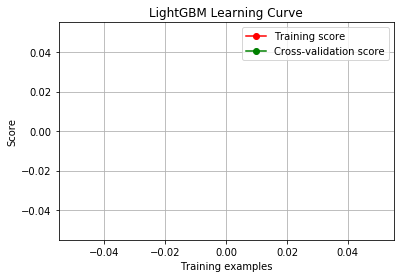

In [30]:
plot_learning_curve(lgb, 'LightGBM Learning Curve', X_train_vect, y_train, cv=5)

In [13]:
lgb = LGBMRegressor(objective = 'regression_l1',
                    subsample = 0.1,
                     random_state = 0,
                     num_leaves = 120,
                     n_estimators = 500,
                     min_split_gain = 0.06999,
                     min_data_in_leaf = 12,
                     max_depth = 56,
                     learning_rate = 0.005,
                     colsample_bytree = 0.4,
                     boosting_type = 'gbdt')

<module 'matplotlib.pyplot' from 'C:\\Users\\DP\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

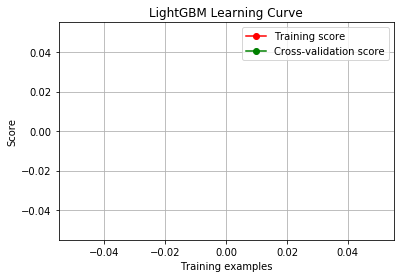

In [34]:
plot_learning_curve(lgb, 'LightGBM Learning Curve', X_train_vect, y_train, cv=5)

In [11]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

In [12]:
gbm = lgb.LGBMRegressor(**hyper_params)

AttributeError: 'LGBMRegressor' object has no attribute 'LGBMRegressor'

In [77]:
gbm.fit(X_train_vect, y_train,
        eval_set=[(X_test_vect, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

AttributeError: module 'lightgbm' has no attribute 'fit'